# Backtesting the AI Investor
Chapter 5 of the book: "Build Your Own AI Investor"

In [1]:
# Code from Book: Build Your Own AI Investor
# Damon Lee 2021
# Check out the performance on www.valueinvestingai.com
# Code uses data from the (presumably) nice people at https://simfin.com/. 
# Feel free to fork this code for others to see what can be done with it.

import pandas as pd
import numpy as np
import math
import pickle # get the ML model from other notebook
from matplotlib import pyplot as plt # scatter plot
import matplotlib.lines as mlines # plot

In [2]:
# Set the plotting DPI settings to be a bit higher.
plt.rcParams['figure.figsize'] = [7.0, 4.5]
plt.rcParams['figure.dpi'] = 150

In [3]:
from platform import python_version
print(python_version())

3.9.17


In [5]:
def loadXandyAgain(randRows=False):
    '''
    Load X and y.
    Randomises rows.
    Returns X, y.
    '''
    # Read in data
    X=pd.read_csv("Annual_Stock_Price_Fundamentals_Ratios.csv",
                  index_col=0)
    y=pd.read_csv("Annual_Stock_Price_Performance_Percentage.csv",
                  index_col=0)
    y=y["Perf"] # We only need the % returns as target
    
    if randRows:
        # randomize the rows
        X['y'] = y
        X = X.sample(frac=1.0, random_state=42) # randomize the rows
        y = X['y']
        X.drop(columns=['y'], inplace=True)

    return X, y

# Train a model from here for backtest
Otherwise train a model in previous notebook, where data will be loaded into this notebook.

We select stocks in a backtest with a picked, pretrained model.

The the train set trains the mdoel the test set is sent to the backtester.

In [6]:
X, y = loadXandyAgain()

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.5, 
                                                    random_state=42)

# Save CSVs 
# For the backtester to get correct test data
# in case want to see the data.
X_train.to_csv("Annual_Stock_Price_Fundamentals_Ratios_train.csv")
X_test.to_csv("Annual_Stock_Price_Fundamentals_Ratios_test.csv")
y_train.to_csv("Annual_Stock_Price_Performance_Percentage_train.csv")
y_test.to_csv("Annual_Stock_Price_Performance_Percentage_test.csv")

# Linear
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import pickle # To save the fitted model

pl_linear = Pipeline([('Power Transformer', PowerTransformer()),
    ('linear', LinearRegression())]).fit(X_train, y_train)

y_pred = pl_linear.predict(X_test)

print('train mse: ', 
      mean_squared_error(y_train, pl_linear.predict(X_train)))
print('test mse: ',
      mean_squared_error(y_test, y_pred))

pickle.dump(pl_linear, open("pl_linear.p", "wb" ))

train mse:  1.3467936259272677
test mse:  1.6607985575360678


Or can use Random Forest

In [7]:
X, y = loadXandyAgain()

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Save CSVs 
# For the backtester to get correct test data
# in case want to see the data.
X_train.to_csv("Annual_Stock_Price_Fundamentals_Ratios_train.csv")
X_test.to_csv("Annual_Stock_Price_Fundamentals_Ratios_test.csv")
y_train.to_csv("Annual_Stock_Price_Performance_Percentage_train.csv")
y_test.to_csv("Annual_Stock_Price_Performance_Percentage_test.csv")

# Forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

rfregressor = RandomForestRegressor(random_state=42, max_depth=10).fit(X_train, y_train)

y_pred = rfregressor.predict(X_test)

print('train mse: ', mean_squared_error(y_train, rfregressor.predict(X_train)))
print('test mse: ', mean_squared_error(y_test, y_pred))
import pickle # To save the fitted model
pickle.dump(rfregressor, open("rfregressor.p", "wb" ))

train mse:  0.5333958636033012
test mse:  1.8519604867542374


# Read in Train/Test

In [8]:
# X AND Y
# The backtester needs dates from the old y vector 
# to plot the stock prices.

# Financial ratios 
X=pd.read_csv("Annual_Stock_Price_Fundamentals_Ratios.csv", 
              index_col=0)

# Annual stock performances, with date data.
y_withData=pd.read_csv("Annual_Stock_Price_Performance_Filtered.csv", 
                       index_col=0)

# Convert to date
y_withData["Date"] = pd.to_datetime(y_withData["Date"])
y_withData["Date2"] = pd.to_datetime(y_withData["Date2"])

# X AND Y (splitting for train/test done previously for trained model)
X_train=pd.read_csv("Annual_Stock_Price_Fundamentals_Ratios_train.csv", 
                    index_col=0)
X_test=pd.read_csv("Annual_Stock_Price_Fundamentals_Ratios_test.csv", 
                   index_col=0)
y_train=pd.read_csv("Annual_Stock_Price_Performance_Percentage_train.csv", 
                    index_col=0)
y_test=pd.read_csv("Annual_Stock_Price_Performance_Percentage_test.csv", 
                   index_col=0)

# Get y_withData to correspond to y_test
y_withData_Test=pd.DataFrame()
y_withData_Test=y_withData.loc[y_test.index, :]

# Convert string to datetime
y_withData_Test["Date"] = pd.to_datetime(y_withData_Test["Date"])
y_withData_Test["Date2"] = pd.to_datetime(y_withData_Test["Date2"])

In [9]:
y_test.head() # y targets

,Perf
20071,-0.390152
17799,0.145266
15017,-0.075223
5496,0.125554
21192,0.094444


In [10]:
y_withData_Test.head() # y data corresponding to y targets

,Ticker,Open Price,Date,Volume,Ticker2,Open Price2,Date2,Volume2
20071,NYMX,7.92,2012-03-15,4.894560e+05,NYMX,4.83,2013-03-15,697935.00
17799,MNK,26.09,2017-11-07,8.944057e+08,MNK,29.88,2018-11-07,68589838.80
15017,KE,23.53,2021-08-27,4.432699e+06,KE,21.76,2022-08-29,819438.08
5496,CHE,532.84,2023-02-27,4.448681e+07,CHE,599.74,2024-02-27,56335377.42
21192,PCYG,5.40,2021-09-28,2.695734e+05,PCYG,5.91,2022-09-28,666848.94


# Z score to account for default chance

In [11]:
def calcZScores(X):
    '''
    Calculate Altman Z'' scores 1995
    '''
    Z = pd.DataFrame()
    Z['Z score'] = 3.25 \
    + 6.51 * X['(CA-CL)/TA']\
    + 3.26 * X['RE/TA']\
    + 6.72 * X['EBIT/TA']\
    + 1.05 * X['Book Equity/TL']
    return Z

In [12]:
z = calcZScores(X)
z.head()

,Z score
0,8.550249
1,5.434905
2,4.013780
3,6.404094
4,7.049565


# Backtest Program

In [139]:
# Daily stock price time series for ALL stocks. 5M rows. Some days missing.
def getYRawData(directory='C:/Users/damon/OneDrive/BYO_Investing_AI/2024/Stock_Data/SimFin2024/'):
    '''
    Can set directory to look for file in.
    Get daily stock price time series for ALL stocks. 
    5M rows. Some days missing.
    Returns DataFrame
    '''
    daily_stock_prices=pd.read_csv(directory+'us-shareprices-daily.csv',
                                   delimiter=';')
    daily_stock_prices["Date"]=pd.to_datetime(daily_stock_prices["Date"])
    print('Reading historical time series stock data, matrix size is: ', 
          daily_stock_prices.shape)
    return daily_stock_prices

In [44]:
def getYPerf(y_):
    y=pd.DataFrame()
    y["Ticker"] = y_["Ticker"]
    y["Perf"]=(y_["Open Price2"]-y_["Open Price"])/y_["Open Price"]
    y[y["Perf"].isnull()]=0
    return y

In [143]:
def getStockPriceBetweenDates(date1, date2, ticker, d, rows):
#     # Alternative way
#     rows = d[(d["Date"].between(pd.to_datetime(date1),\
#                                 pd.to_datetime(date2) )) \
#                                  & (d["Ticker"]==ticker)]
    rows = d.loc[(d["Date"]>date1) &\
                 (d["Date"]<date2) &\
                 (d["Ticker"]==ticker)]
    return rows

<Axes: >

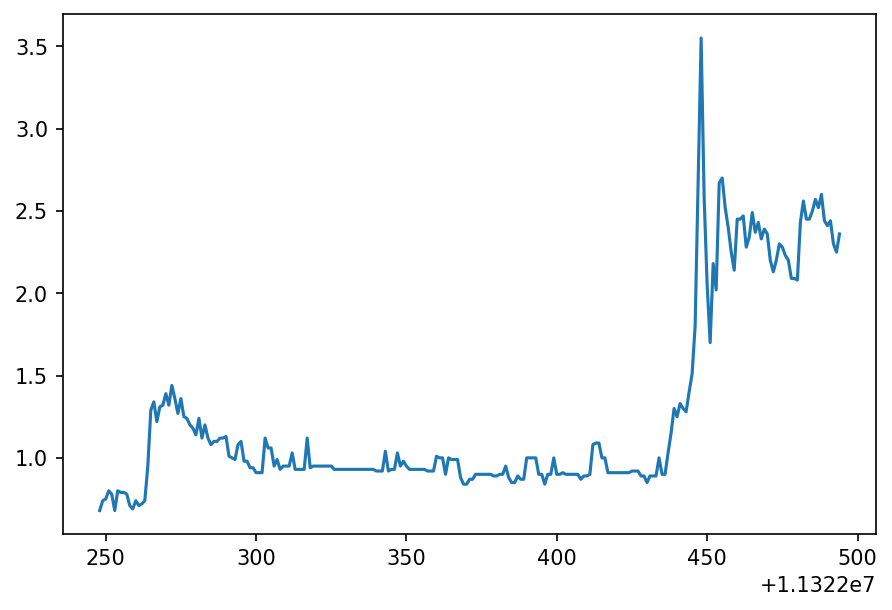

In [146]:
# Example stock price lookup
getStockPriceBetweenDates(pd.to_datetime('2010-03-07'), 
                          pd.to_datetime('2011-02-27'), 
                          'NOTV', daily_stock_prices_data, pd.DataFrame())['Close'].plot()

In [151]:
def getStockPriceData(dateTimeIndex, ticker, y_withData, mask, daily_stock_prices, rows):
    '''
    Get the stock price for a ticker
    between the buy/sell date (using y_withdata)
    2021 version change to select from March to March only, 
    go for more corresponding backtest to reality,
    rather than attampting to match the training data closely.
    '''
    #date1 = y_withData[mask][y_withData[mask]["Ticker"] == ticker]["Date"].values[0]
    #date2 = y_withData[mask][y_withData[mask]["Ticker"] == ticker]["Date2"].values[0]
    date1 = dateTimeIndex[0]
    date2 = dateTimeIndex[-1]
    rows = getStockPriceBetweenDates(date1, date2,\
                                     ticker, daily_stock_prices, rows)
    return rows

In [150]:
def getDataForDateRange(date_Index_New, rows):
    '''
    Given a date range(index), and a series of rows,
    that may not correspond exactly,
    return a DataFrame that gets rows data,
    for each period in the date range(index)
    '''
    WeeklyStockDataRows = pd.DataFrame()
    for I in date_Index_New:
        WeeklyStockDataRows = pd.concat([WeeklyStockDataRows, 
        rows.iloc[rows.index.get_indexer([pd.to_datetime(I)], method="nearest")]], 
                                         ignore_index=True)
    return WeeklyStockDataRows

In [149]:
def getStockTimeSeries(dateTimeIndex, y_withData, 
                       tickers, mask, daily_stock_prices):
    '''
    Get the stock price as a time series DataFrame
    for a list of tickers.
    A mask is used to only consider stocks for a certain period.
    dateTimeIndex is typically a weekly index,
    so we know what days to fetch the price for.
    '''
    stockRet = pd.DataFrame(index=dateTimeIndex)
    dTI_new = dateTimeIndex.strftime('%Y-%m-%d') # Change Date Format
    rows = pd.DataFrame()
    for tick in tickers:
        # Here "rows" is stock price time series data 
        # for individual stock
        rows = getStockPriceData(dateTimeIndex,
                                 tick, 
                                 y_withData, 
                                 mask, 
                                 daily_stock_prices, 
                                 rows)
        rows.index = pd.DatetimeIndex(rows["Date"])
        WeeklyStockDataRows = getDataForDateRange(dTI_new,
                                                  rows)
        # Here can use Open, Close, Adj. Close, etc. price
        stockRet[tick] = WeeklyStockDataRows["Close"].values
    return stockRet

<Axes: >

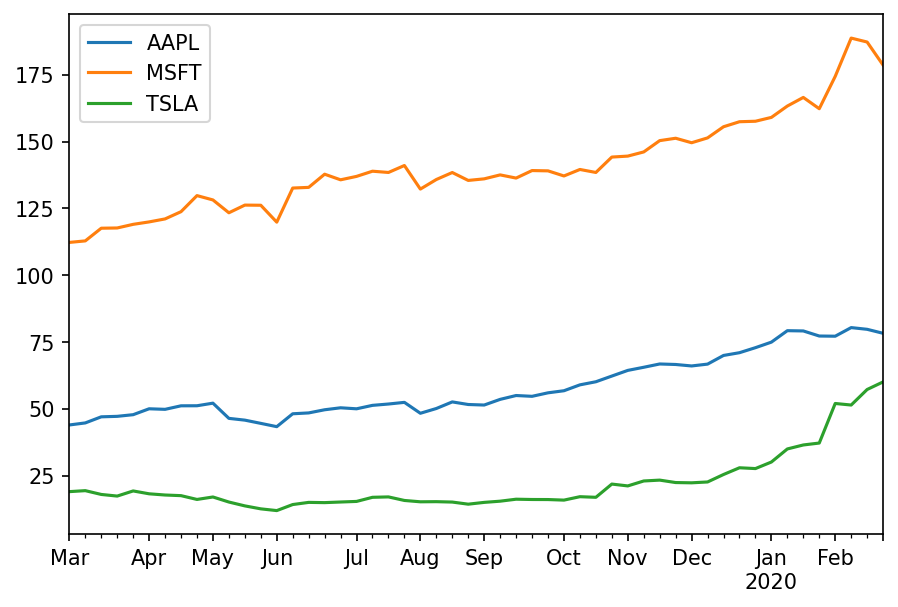

In [166]:
# Example stock price series lookup
weeklyDateTimeIndex = pd.date_range(start='2019-03-01', 
                                    periods=52, 
                                    freq='W')

stocksPrices = getStockTimeSeries(weeklyDateTimeIndex, 
                                  y_withData='notused', 
                                  tickers=['AAPL', 'MSFT','TSLA'], 
                                  mask='notused',
                                  daily_stock_prices=daily_stock_prices_data)

stocksPrices.plot()

In [66]:
def getPortfolioRelativeTimeSeries(stockRet):
    '''
    Takes DataFrame of stock returns, one column per stock
    Normalises all the numbers so the price at the start is 1.
    Adds a column for the portfolio value.
    '''    
    for key in stockRet.keys():
        stockRet[key]=stockRet[key]/stockRet[key][0]
    stockRet["Portfolio"] = stockRet.sum(axis=1)/(stockRet.keys().shape[0])
    return stockRet

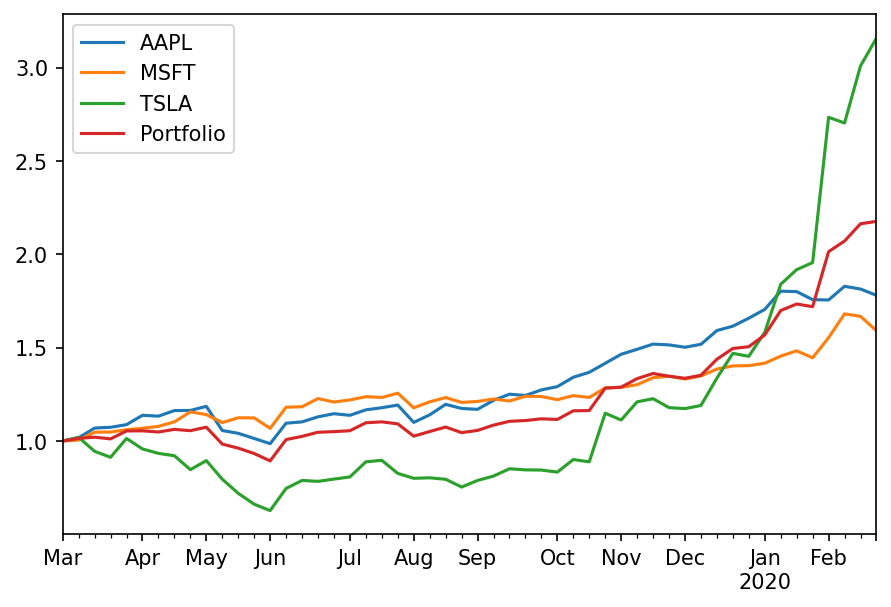

In [167]:
getPortfolioRelativeTimeSeries(stocksPrices).plot();

In [67]:
### First tutorial function reader will write for backtest, will add altmanZ score filter later in chapter. ###
def getPortTimeSeriesForYear(date_starting, y_withData, X, 
                             daily_stock_prices, ml_model_pipeline):
    '''
    Function runs a backtest.
    Returns DataFrames of selected stocks/portfolio performance,
    for 1 year.
    y_withData is annual stock performances (all backtest years)
    date_starting e.g. '2010-01-01'
    daily_stock_prices is daily(mostly) stock price time series for 
    all stocks
    '''
    
    # get y dataframe as ticker and ticker performance only
    y = getYPerf(y_withData)
    
    # Get performance only for stock reports
    # published in the time frame we care about,
    # mask original data using the start date
    # "Date" is the publication date.
    thisYearMask = y_withData["Date"].between(\
            pd.to_datetime(date_starting) - pd.Timedelta(days=60),\
            pd.to_datetime(date_starting))
    
    # Get return prediction from model
    y_pred = ml_model_pipeline.predict(X[thisYearMask])
    
    # Make it a DataFrame to select the top picks
    y_pred = pd.DataFrame(y_pred)
    
    # Bool list of top stocks
    bl_bestStocks=(y_pred[0]>y_pred.nlargest(8,0).tail(1)[0].values[0]) 
    
    # DatetimeIndex
    dateTimeIndex = pd.date_range(start=date_starting, 
                                  periods=52, 
                                  freq='W')
    
    # 7 greatest performance stocks of y_pred 
    ticker_list = y[thisYearMask].reset_index(drop=True)\
                  [bl_bestStocks]["Ticker"].values
    
    # Issue with one of the tickers equaling 0, fix with lambda function
    #ticker_list = list(filter(lambda dateTimeIndex: dateTimeIndex != 0, ticker_list))

    # After we know our stock picks, we get the stock performance
    # Get DataFrame index of time stamp, series of stock prices, keys=tickers
    stockRet = getStockTimeSeries(dateTimeIndex, y_withData, 
                                  ticker_list, thisYearMask, 
                                  daily_stock_prices)
    
    # Get DataFrame of relative stock prices from 
    # 1st day(or close) and whole portfolio
    stockRetRel = getPortfolioRelativeTimeSeries(stockRet)
    return [stockRetRel, stockRetRel["Portfolio"], ticker_list]

In [68]:
### Proper function ###
def getPortTimeSeriesForYear(date_starting, y_withData, X, 
                             daily_stock_prices, ml_model_pipeline):
    '''
    Function runs a backtest.
    Returns DataFrames of selected stocks/portfolio performance,
    for 1 year.
    y_withData is annual stock performances (all backtest years)
    date_starting e.g. '2010-01-01'
    daily_stock_prices is daily(mostly) stock price time series for
    all stocks
    '''
    
    # get y dataframe with ticker performance only
    y = getYPerf(y_withData)
    
    # Get performance only for time frame we care about,
    # mask original data using the start date
    thisYearMask = y_withData["Date"].between(\
              pd.to_datetime(date_starting) - pd.Timedelta(days=120),######
              pd.to_datetime(date_starting))
    
    
    # Get return prediction from model
    y_pred = ml_model_pipeline.predict(X[thisYearMask])
    
    # Make it a DataFrame to select the top picks
    y_pred = pd.DataFrame(y_pred)
    
    ##### Change in code for Z score filtering ##### 
    # Separate out stocks with low Z scores
    z = calcZScores(X)
    
    # 3.75 is approx. B- rating
    bl_safeStocks=(z['Z score'][thisYearMask].reset_index(drop=True)>2) 
    y_pred_z = y_pred[bl_safeStocks]
    
    # Get bool list of top stocks
    bl_bestStocks=(
        y_pred_z[0]>y_pred_z.nlargest(8,0).tail(1)[0].values[0]) 
    
    dateTimeIndex = pd.date_range(\
                          start=date_starting, periods=52, freq='W')
    
    # 7 greatest performance stocks of y_pred 
    ticker_list = \
    y[thisYearMask].reset_index(drop=True)\
                      [bl_bestStocks&bl_safeStocks]["Ticker"].values
    ##### Change in code for Z score filtering ##### 
    
    # After we know our stock picks, we get the stock performance
    # Get DataFrame index of time stamp, series of stock prices, 
    # keys=tickers
    stockRet = getStockTimeSeries(dateTimeIndex, y_withData,
                                  ticker_list, thisYearMask, 
                                  daily_stock_prices)
    
    # Get DataFrame of relative stock prices from 1st day(or close) 
    # and whole portfolio
    stockRetRel = getPortfolioRelativeTimeSeries(stockRet)
    return [stockRetRel, stockRetRel["Portfolio"], ticker_list]

In [156]:
def getPortTimeSeries(y_withData, X, daily_stock_prices, ml_model_pipeline, verbose=True):
    '''
    Returns DataFrames of selected stocks/portfolio performance since 2009.
    Needs X and y(with data), the daily_stock_prices DataFrame,
    the model pipeline we want to test.
    X is standard X for model input.
    y_withData is the stock price before/after df with date information.
    Input X and y must be data that the model was not trained on.
    '''
    # set date range to make stock picks over
    dr=pd.date_range(start='2006-01-01', periods=16, freq='Y') + pd.to_timedelta('9w') # start every March
    # For each date in the date_range, make stock selections
    # and plot the return results of those stock selections
    port_perf_all_years = pd.DataFrame()
    perfRef=1 # performance starts at 1.
    for curr_date in dr:
        
        [comp, this_year_perf, ticker_list] = \
        getPortTimeSeriesForYear(curr_date, y_withData, X,\
                                 daily_stock_prices, ml_model_pipeline)
        
        if verbose: # If you want text output
            print("Backtest performance for year starting ",\
                  curr_date, " is:",\
                  round((this_year_perf.iloc[-1]-1)*100,2), "%")
            print("With stocks:", ticker_list)
            for tick in ticker_list:
                print(tick, "Performance was:",\
                      round((comp[tick].iloc[-1]-1)*100,2), "%" )
            print("---------------------------------------------")
        
        # Stitch performance for every year together
        this_year_perf = this_year_perf * perfRef
        #print(comp)
        port_perf_all_years = pd.concat([port_perf_all_years,\
                                         this_year_perf])
        
        perfRef = this_year_perf.iloc[-1]
    
    # Return portfolio performance for all years
    port_perf_all_years.columns = ["Indexed Performance"]
    return port_perf_all_years

# Run a Backtest

In [140]:
daily_stock_prices_data=getYRawData()

Reading historical time series stock data, matrix size is:  (17999010, 11)


In [53]:
y_withData_Test

,Ticker,Open Price,Date,Volume,Ticker2,Open Price2,Date2,Volume2
20071,NYMX,7.92,2012-03-15,4.894560e+05,NYMX,4.83,2013-03-15,697935.00
17799,MNK,26.09,2017-11-07,8.944057e+08,MNK,29.88,2018-11-07,68589838.80
15017,KE,23.53,2021-08-27,4.432699e+06,KE,21.76,2022-08-29,819438.08
5496,CHE,532.84,2023-02-27,4.448681e+07,CHE,599.74,2024-02-27,56335377.42
21192,PCYG,5.40,2021-09-28,2.695734e+05,PCYG,5.91,2022-09-28,666848.94
...,...,...,...,...,...,...,...,...
25737,SPLS,13.18,2002-04-04,4.894788e+07,SPLS,12.88,2003-04-04,50355648.00
23143,RDWR,29.12,2021-04-20,1.597651e+07,RDWR,31.41,2022-04-20,5652575.01
19431,NPO,19.75,2004-03-03,1.072425e+06,NPO,29.03,2005-03-03,3271681.00
7696,DAR,12.73,2017-02-28,3.306695e+07,DAR,18.15,2018-02-28,30238970.85


In [54]:
X_test

,EV/EBIT,Op. In./(NWC+FA),P/E,P/B,P/S,Op. In./Interest Expense,Working Capital Ratio,RoE,ROCE,Debt/Equity,Debt Ratio,Cash Ratio,Asset Turnover,Gross Profit Margin,(CA-CL)/TA,RE/TA,EBIT/TA,Book Equity/TL
20071,-26.300988,-3.286465,-26.840457,-50.000000,83.201646,-355.676853,1.847635,2.011938,-2.000000,0.000000,0.570605,1.726090,140.515117,0.906910,0.455921,-12.878842,-1.509792,-0.429395
17799,10.170925,0.277973,1.196688,0.391630,0.792839,1.256790,2.175552,0.327262,0.055232,1.352193,1.739540,1.200400,7.796709,0.514123,0.080490,0.168737,0.051450,0.739540
15017,7.691730,0.147359,10.475824,1.346086,0.460543,31.848279,1.939639,0.128495,0.140500,0.841884,2.187813,0.353894,7.913011,0.091372,0.347172,0.256699,0.088589,1.187813
5496,24.138852,1.961478,32.229878,10.072868,3.768380,74.933682,0.917252,0.312532,0.291982,0.805415,2.241596,0.249410,10.690102,0.358360,-0.017055,1.524202,0.231803,1.241596
21192,25.480207,0.125810,30.210445,2.363082,5.077889,-22.148879,3.193470,0.078221,0.076012,0.219446,5.556925,2.587989,8.113365,0.672270,0.370611,-0.533362,0.063169,4.556925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25737,18.973649,0.239567,32.950000,4.250254,0.812589,19.062897,1.505815,0.128991,0.183421,0.992545,2.007511,0.247430,7.907531,0.239241,0.197195,0.311014,0.111913,1.007511
23143,206.018224,0.027168,144.268930,3.578674,5.560101,-0.791175,2.419543,0.024806,0.012863,0.604447,2.654405,0.831009,10.882094,0.819683,0.327397,0.214607,0.009896,1.654405
19431,8.252429,0.210255,12.267081,0.932815,0.557824,8.578947,1.843420,0.076042,0.072000,1.337838,1.747475,0.454851,5.428253,0.313656,0.172039,0.024983,0.057314,0.747475
7696,17.643207,0.077908,20.532258,1.011798,0.618201,1.618780,1.976984,0.049278,0.049884,1.262772,1.791909,0.253544,2.242129,0.222588,0.093965,0.181524,0.045086,0.791909


In [157]:
trained_model_pipeline = pickle.load(open("rfregressor.p", "rb" ))

backTest = getPortTimeSeries(y_withData_Test, X_test, 
                         daily_stock_prices_data, 
                         trained_model_pipeline)
print('Performance is: ', 100 * (backTest["Indexed Performance"][-1]-1), '%')

Backtest performance for year starting  2007-03-04 00:00:00  is: 2.93 %
With stocks: ['EQIX' 'RICK' 'AAL' 'SNX' 'INT' 'F' 'RRD']
EQIX Performance was: -10.96 %
RICK Performance was: 145.79 %
AAL Performance was: -73.09 %
SNX Performance was: 15.86 %
INT Performance was: -31.14 %
F Performance was: -17.55 %
RRD Performance was: -8.44 %
---------------------------------------------
Backtest performance for year starting  2008-03-03 00:00:00  is: -28.75 %
With stocks: ['F' 'AAL' 'INT' 'SNX' 'GFF' 'MTH' 'ALR']
F Performance was: -64.29 %
AAL Performance was: -72.3 %
INT Performance was: 12.05 %
SNX Performance was: -28.41 %
GFF Performance was: -2.81 %
MTH Performance was: -21.58 %
ALR Performance was: -23.93 %
---------------------------------------------
Backtest performance for year starting  2009-03-04 00:00:00  is: 455.43 %
With stocks: ['FVE' 'HUN' 'BZH' 'BC' 'KATE' 'SNX' 'TEX']
FVE Performance was: 179.82 %
HUN Performance was: 458.13 %
BZH Performance was: 1564.0 %
BC Performance w

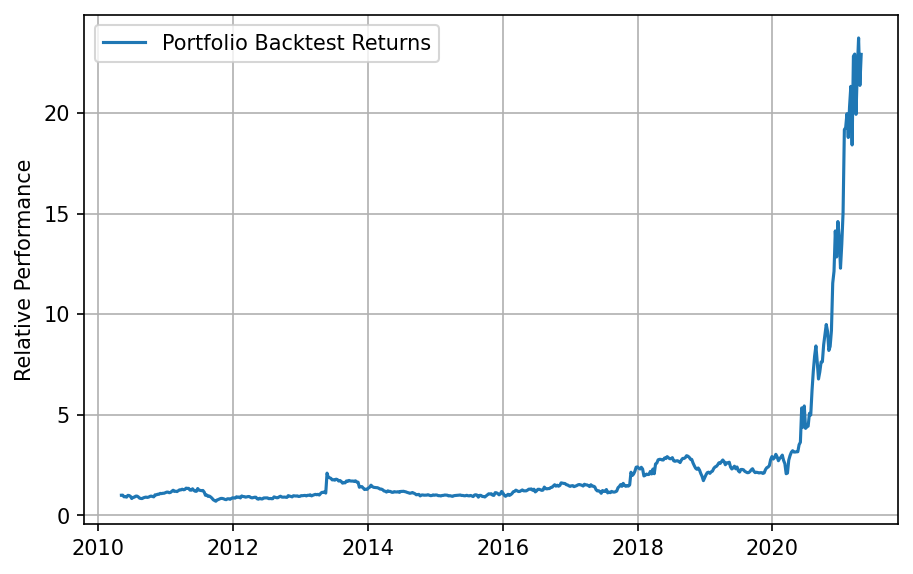

In [102]:
plt.plot(backTest)
plt.grid()
plt.legend(['Portfolio Backtest Returns'])
plt.ylabel('Relative Performance');

In [189]:
open_price

Date
2022-01-03 00:00:00-05:00    4778.140137
2022-01-04 00:00:00-05:00    4804.509766
2022-01-05 00:00:00-05:00    4787.990234
2022-01-06 00:00:00-05:00    4693.390137
2022-01-07 00:00:00-05:00    4697.660156
                                ...     
2024-03-18 00:00:00-04:00    5154.770020
2024-03-19 00:00:00-04:00    5139.089844
2024-03-20 00:00:00-04:00    5181.689941
2024-03-21 00:00:00-04:00    5253.430176
2024-03-22 00:00:00-04:00    5242.479980
Name: Open, Length: 558, dtype: float64

volatility of AI investor was:  12.632673241293089
volatility of S&P 500 was:  0.29600663289321993


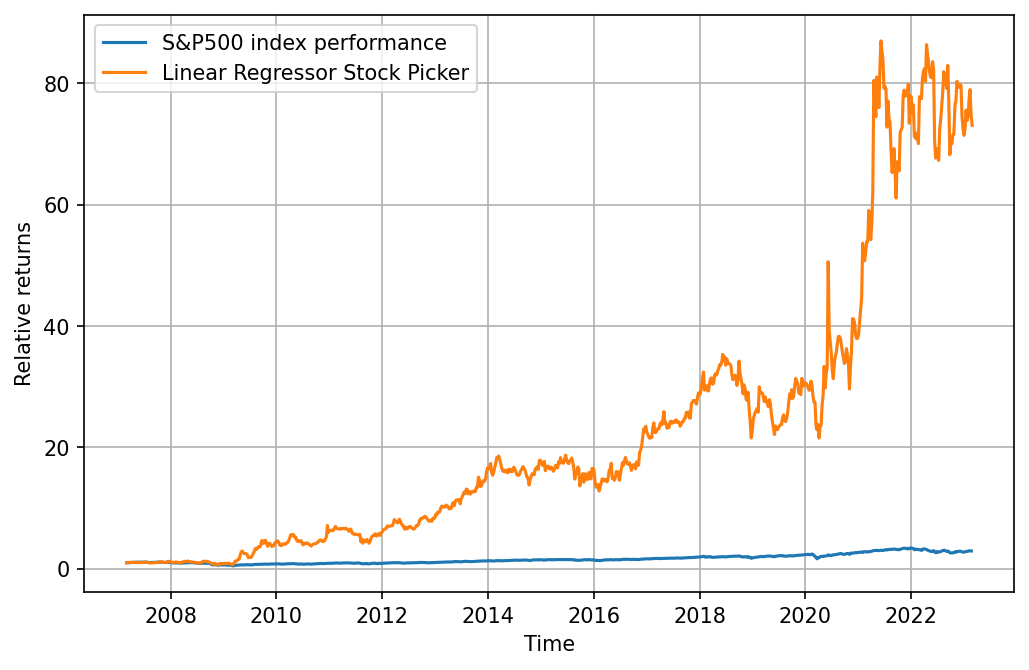

In [191]:
import pandas as pd
from matplotlib import pyplot as plt
import yfinance as yf

# Replace 'AAPL' with the ticker symbol of the stock you want to fetch data for
ticker_symbol = '^GSPC'

# Create a yfinance object for the specified stock
stock = yf.Ticker(ticker_symbol)

# Start and end dates
start = pd.to_datetime(backTest.index[0])
end = pd.to_datetime(backTest.index[-1])

# Use the Pandas DataReader
spy = stock.history(start=start, end=end)
spy = spy.asfreq('W-MON', method='pad') # Weekly
spy['Relative'] = spy["Open"]/spy["Open"][0]

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8,5))
plt.plot(spy['Relative'])
plt.plot(backTest)
plt.grid()
plt.xlabel('Time')
plt.ylabel('Relative returns')
plt.legend(['S&P500 index performance', 'Linear Regressor Stock Picker'])
#plt.savefig('spy.png')
print('volatility of AI investor was: ', backTest['Indexed Performance'].diff().std()*np.sqrt(52))
print('volatility of S&P 500 was: ', spy["Relative"].diff().std()*np.sqrt(52))

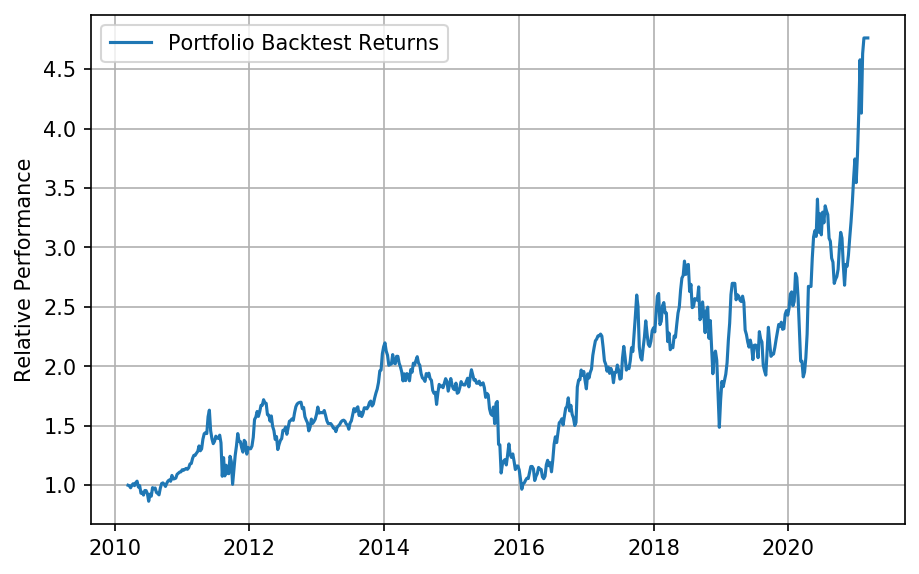

In [126]:
plt.plot(backTest)
plt.grid()
plt.legend(['Portfolio Backtest Returns'])
plt.ylabel('Relative Performance');

# Investigating The Results

In [25]:
x_=pd.read_csv("Annual_Stock_Price_Fundamentals_Filtered.csv",
               index_col=0)

In [22]:
date_starting = '2019-01-01'

thisYearMask = y_withData["Date"].between(\
        pd.to_datetime(date_starting) - pd.Timedelta(days=60),\
        pd.to_datetime(date_starting))

In [27]:
x_[thisYearMask][['Report Date', 'Publish Date']]

,Report Date,Publish Date
10,2018-10-31,2018-12-20
69,2018-09-30,2018-11-05
113,2018-09-30,2018-11-20
148,2018-10-31,2018-12-21
255,2018-09-30,2018-11-13
...,...,...
14581,2018-09-30,2018-11-16
14792,2018-09-30,2018-11-21
14824,2018-09-30,2018-11-16
15126,2018-08-31,2018-11-29


In [128]:
y_small=getYPerf(y_withData_Test)
# y_small is cut down version of y with stock returns only

# Create a boolean mask for the backtest year we are interested in
myDate = pd.to_datetime('2015-03-07 07:00:00')
mask2015 = y_withData_Test["Date"].between( pd.to_datetime(myDate)
                                       -pd.Timedelta(days=60), 
                                       pd.to_datetime(myDate))

#y_withData_Test[mask2015] # Checking the mask works
#X[mask2015]

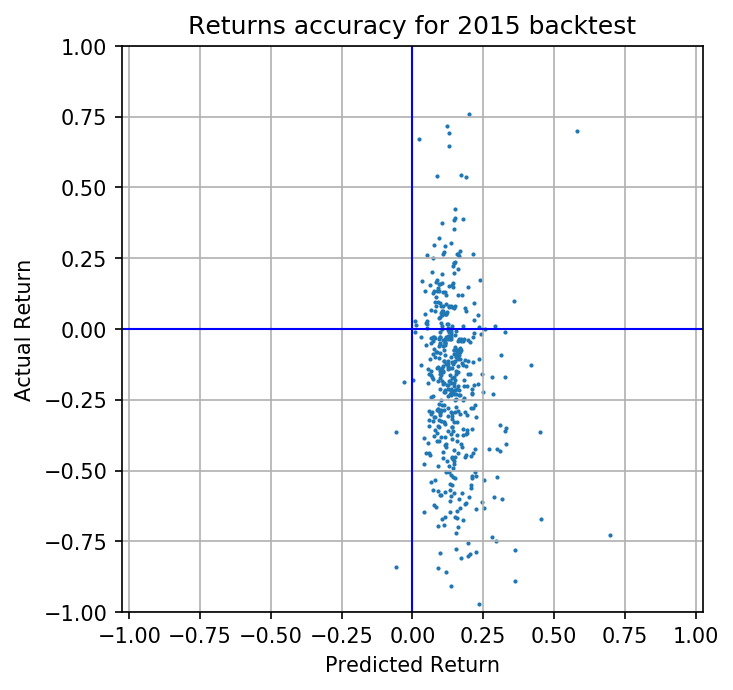

In [129]:
# Load the model pipeline
ml_model_pipeline = pickle.load(open("pl_linear.p", "rb" ))
y_pred = ml_model_pipeline.predict(X_test[mask2015]) # Get stock performance predictions
y_pred = pd.DataFrame(y_pred) # Turn into DataFrame

plt.figure(figsize=(5,5))
# Now output graph.
from matplotlib import pyplot as plt
import matplotlib.lines as mlines
plt.scatter(y_pred[0], y_small[mask2015]["Perf"], s=1)
# Formatting
plt.grid()
plt.axis('equal')
plt.title('Returns accuracy for {} backtest'.format(myDate.year))
plt.xlabel('Predicted Return')
plt.ylabel('Actual Return')
plt.axvline(c='blue', lw=1)
plt.axhline(c='blue', lw=1)
plt.savefig('result.png')
plt.axis([-1,1,-1,1]);

In [130]:
# Top stocks picked, and predicted performance.
bl = (y_pred[0] > y_pred.nlargest(8,0).tail(1)[0].values[0])

print("\nTop predicted perf. stocks picked are:")
print(y_small[mask2015].reset_index(drop=True)[bl]["Ticker"])
print("\nTop stocks predicted performance is:")
print(y_pred[bl])


print("\nActual performance was: ")
print(y_small[mask2015].reset_index(drop=True)[bl])

# Calc Altman Z score:
Z = 3.25 \
+ 6.51 * X_test[mask2015].reset_index(drop=True)[bl]['(CA-CL)/TA']\
+ 3.26 * X_test[mask2015].reset_index(drop=True)[bl]['RE/TA']\
+ 6.72 * X_test[mask2015].reset_index(drop=True)[bl]['EBIT/TA']\
+ 1.05 * X_test[mask2015].reset_index(drop=True)[bl]['Book Equity/TL']
print('\nZ scores:\n',Z)


Top predicted perf. stocks picked are:
24     AXGN
50      FRP
137    TTPH
305    NURO
343    CNXR
359    INVA
405     CLF
Name: Ticker, dtype: object

Top stocks predicted performance is:
            0
24   0.579731
50   0.417433
137  0.364022
305  0.361798
343  0.455764
359  0.450412
405  0.697863

Actual performance was: 
    Ticker      Perf
24    AXGN  0.699060
50     FRP -0.127873
137   TTPH -0.890617
305   NURO -0.779241
343   CNXR -0.671378
359   INVA -0.364440
405    CLF -0.726597

Z scores:
 24    -14.805369
50      0.698270
137     6.709271
305   -40.232902
343    -2.000570
359    -6.243600
405   -13.691849
dtype: float64


In [131]:
# bool list of 7 greatest performance stocks of y_pred 
bl_bestStocks = (y_pred[0] > y_pred.nlargest(8,0).tail(1)[0].values[0])

# See what the performance is of the selection
print("Backtest return is:")
print(y_small[mask2015]["Perf"].reset_index(drop=True)[bl_bestStocks].values.mean())

Backtest return is:
-0.40872660177634523


In [132]:
#d = getYRawData()

In [133]:
y_withData_Test[mask2015]

,Ticker,Open Price,Date,Volume,Ticker2,Open Price2,Date2,Volume2
15520,ZG,103.20,2015-02-05,1.033457e+08,ZG,19.66,2016-02-05,18225390.14
7364,IRBT,31.11,2015-02-13,8.205667e+06,IRBT,29.98,2016-02-16,7818004.52
13762,TPX,13.42,2015-02-13,1.805848e+07,TPX,13.64,2016-02-16,14709853.40
5479,FII,35.02,2015-02-20,1.396118e+07,FII,25.24,2016-02-22,19946389.56
12899,SPOK,18.74,2015-03-05,1.519383e+06,SPOK,17.36,2016-03-04,1180861.92
...,...,...,...,...,...,...,...,...
1872,BGCP,5.82,2015-03-02,7.821562e+06,BGCP,5.58,2016-03-01,9093447.00
9681,NANO,17.91,2015-02-25,8.040515e+05,NANO,13.73,2016-02-25,782253.02
8879,MCO,97.31,2015-02-26,7.594647e+07,MCO,88.35,2016-02-26,80843077.20
11222,PRLB,71.59,2015-02-27,1.224189e+07,PRLB,65.20,2016-02-29,10446018.00


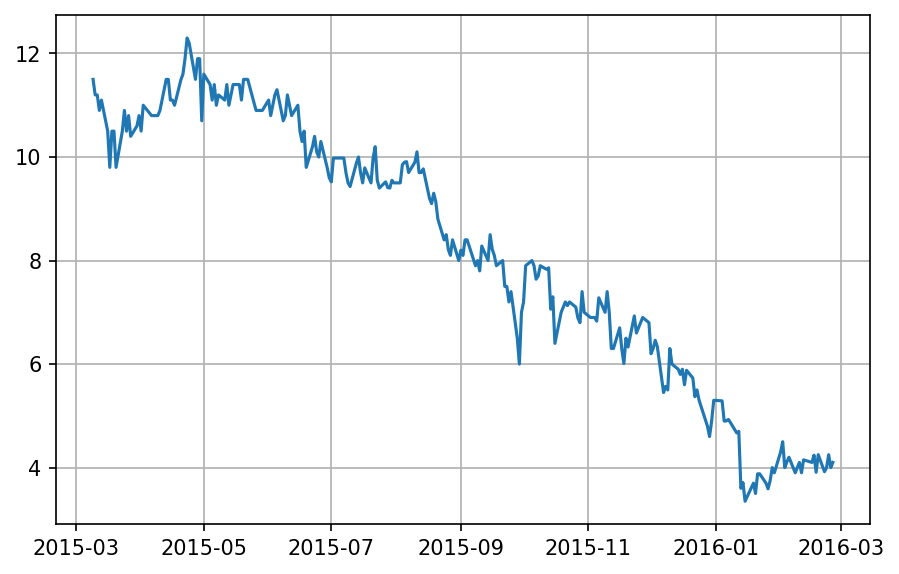

In [134]:
dateTimeIndex2015 = pd.date_range(\
                    start='2015-03-07', 
                              periods=52, 
                              freq='W')
    
rows = getStockPriceData(dateTimeIndex2015, "BXC", y_withData_Test, mask2015, d, rows=pd.DataFrame())
plt.plot(rows["Date"], rows["Close"]) # Adj. Close
plt.grid(True)

In [135]:
rows

,Ticker,SimFinId,Date,Open,Low,High,Close,Adj. Close,Dividend,Volume,Shares Outstanding
4675446,BXC,673388,2015-03-09,11.50,11.35,11.60,11.50,11.50,NaN,29404,8941624.0
4675447,BXC,673388,2015-03-10,11.10,10.60,11.40,11.20,11.20,NaN,36171,8941624.0
4675448,BXC,673388,2015-03-11,11.40,11.00,11.40,11.20,11.20,NaN,13609,8941624.0
4675449,BXC,673388,2015-03-12,11.00,10.90,11.20,10.90,10.90,NaN,43436,8941624.0
4675450,BXC,673388,2015-03-13,10.90,10.79,11.10,11.10,11.10,NaN,45761,8941624.0
...,...,...,...,...,...,...,...,...,...,...,...
4675687,BXC,673388,2016-02-22,4.50,3.90,4.50,3.92,3.92,NaN,48270,89430000.0
4675688,BXC,673388,2016-02-23,4.00,3.72,4.00,4.00,4.00,NaN,29729,89430000.0
4675689,BXC,673388,2016-02-24,4.20,3.70,4.25,4.25,4.25,NaN,15604,89430000.0
4675690,BXC,673388,2016-02-25,4.25,3.70,4.25,4.00,4.00,NaN,61865,89430000.0


# See how individual stocks performed
With the program functions used individually

In [136]:
# Make X ticks standard, and grab stock prices as close to those points as possible for each stock (To track performance)

#DatetimeIndex
date_range = pd.date_range(start=myDate, periods=52, freq='W')

# 7 greatest performance stocks of y_pred 
ticker_list = y_withData_Test[mask2015].reset_index(drop=True)[bl_bestStocks]["Ticker"].values
stockRet = getStockTimeSeries(date_range, y_withData_Test, ticker_list , mask2015, d)

In [137]:
y_small

,Ticker,Perf
7217,INTC,0.616757
12508,SIX,0.184577
14996,WHR,0.524234
5852,FUEL,0.153191
8857,MCHP,0.039030
...,...,...
8845,MCD,0.232620
12718,SNDK,0.090199
2379,CA,0.152164
11142,POST,0.077282


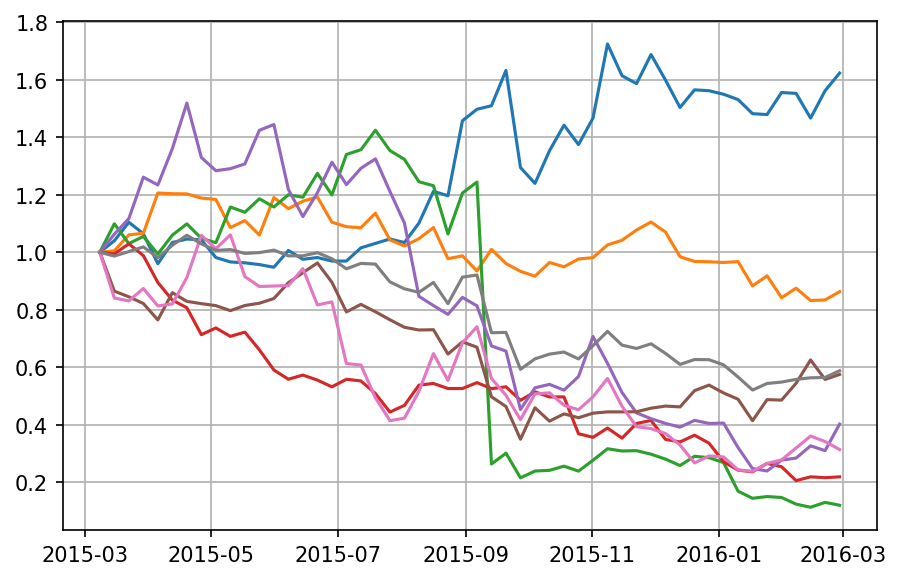

In [138]:
#make X ticks standard, and grab stock prices as close to
# those points as possible for each stock (To track performance)

#DatetimeIndex
date_range = pd.date_range(start=myDate, periods=52, freq='W') 

bl = (y_pred[0] > y_pred.nlargest(8,0).tail(1)[0].values[0])

# 7 greatest performance stocks of y_pred 
ticker_list = y_small[mask2015].reset_index(drop=True)[bl_bestStocks]["Ticker"].values

stockRet = getStockTimeSeries(date_range, y_withData_Test, 
                              ticker_list, 
                              mask2015, 
                              daily_stock_prices_data)

stockRetRel = getPortfolioRelativeTimeSeries(stockRet)

stockRetRel.head()

plt.plot(stockRetRel);
plt.grid()


In [139]:
stockRetRel = getPortfolioRelativeTimeSeries(stockRet)

In [140]:
stockRetRel.head(20)

,AXGN,FRP,TTPH,NURO,CNXR,INVA,CLF,Portfolio
2015-03-08 07:00:00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2015-03-15 07:00:00,1.039877,1.004828,1.098889,0.994152,1.062574,0.864851,0.841105,0.986611
2015-03-22 07:00:00,1.104294,1.060350,1.030000,1.029240,1.116883,0.845050,0.830743,1.002366
2015-03-29 07:00:00,1.064417,1.065782,1.055000,0.988304,1.260921,0.821782,0.873921,1.018589
2015-04-05 07:00:00,0.960123,1.205794,0.993889,0.894737,1.233766,0.764851,0.813472,0.980947
2015-04-12 07:00:00,1.033742,1.203380,1.059444,0.833681,1.360094,0.859406,0.820380,1.024304
2015-04-19 07:00:00,1.046012,1.202776,1.098611,0.807018,1.518300,0.829208,0.911917,1.059120
2015-04-26 07:00:00,1.042945,1.188292,1.048333,0.713505,1.329398,0.821287,1.058722,1.028926
2015-05-03 07:00:00,0.981595,1.183464,1.033056,0.736842,1.283353,0.814356,1.012090,1.006394
2015-05-10 07:00:00,0.966258,1.085697,1.157222,0.707602,1.290437,0.797030,1.060449,1.009242


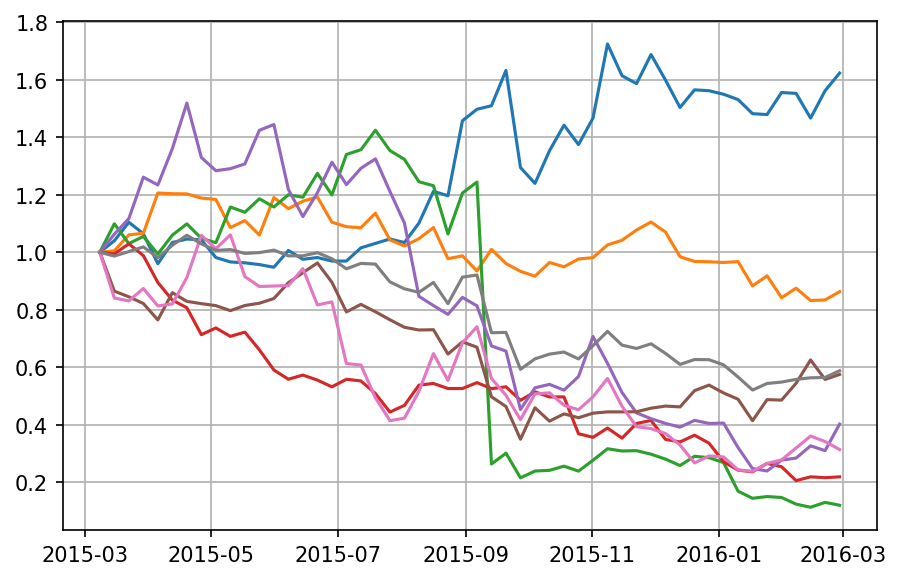

In [141]:
plt.plot(stockRetRel);
plt.grid()

# Plot backtest with S&P500

volatility of AI investor was:  0.9202778619020442
volatility of S&P 500 was:  0.325059094152396


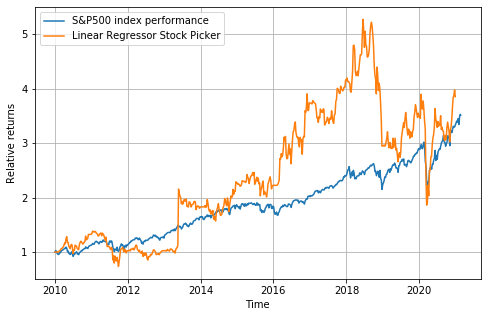

In [29]:
# GSPC.csv taken directly from Yahoo.com is the S&P500.
# https://finance.yahoo.com/quote/%5EGSPC/history?period1=1235174400&period2=1613865600&interval=1wk&filter=history&frequency=1wk&includeAdjustedClose=true
spy=pd.read_csv("GSPC.csv", index_col='Date', parse_dates=True)
spy = spy[spy.index > pd.to_datetime('2010-01-01')]
spy['Relative'] = spy["Open"]/spy["Open"][0]

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8,5))
plt.plot(spy['Relative'])
plt.plot(backTest)
plt.grid()
plt.xlabel('Time')
plt.ylabel('Relative returns')
plt.legend(['S&P500 index performance', 'Linear Regressor Stock Picker'])
#plt.savefig('spy.png')
print('volatility of AI investor was: ', backTest['Indexed Performance'].diff().std()*np.sqrt(52))
print('volatility of S&P 500 was: ', spy["Relative"].diff().std()*np.sqrt(52))

In [31]:
spy.iloc[-1]

Open         3.921160e+03
High         3.930410e+03
Low          3.903070e+03
Close        3.906710e+03
Adj Close    3.906710e+03
Volume       2.302435e+09
Relative     3.511822e+00
Name: 2021-02-19 00:00:00, dtype: float64